In [2]:
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)











Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos"

In [3]:
telos = pd.read_csv('./data/telos.csv')
patients_df = pd.read_csv("./data/all_patients.csv")

telo_data = patients_df[patients_df['timepoint']=='4 C'][['patient id','telo means','timepoint']]
telo_data.rename(columns={'telo means':'4 C telo means'},inplace= True)
telo_data = (telos[telos['timepoint'] != '4 C']
        .merge(telo_data[['4 C telo means', 'patient id']], on=['patient id'])
        .drop('telo means',axis=1)
       )
telo_data = telo_data[telo_data['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]

telo_data.shape

(128800, 4)

In [4]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])


In [5]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=1)


In [6]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = pd.get_dummies(train_set,columns=['timepoint']).drop(['patient id','timepoint_1 non irrad'],axis=1)
test_clean = pd.get_dummies(test_set,columns=['timepoint']).drop(['patient id','timepoint_1 non irrad'],axis=1)

In [7]:
target = '4 C telo means'
features = [col for col in train_clean.columns if col != target]

X_train = train_clean[features].copy()
X_test = test_clean[features].copy()

y_train = train_clean[target].copy()
y_test = test_clean[target].copy()

# # cv
# scores = -1 * cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
# print(f'MAE per CV fold: \n{scores} \n')
# print(f'MEAN of MAE all folds: {scores.mean()}')
# print(f'STD of MAE all folds: {scores.std()}\n')


# fitting the model
fit_xgb_model = model.fit(X_train, y_train)

# predict y_test from X_test - this is using the train/test split w/o shuff;ing
predict_y_test = model.predict(X_test)
print(f"MAE of predict_y_test & y_test: {mean_absolute_error(y_test, predict_y_test)}")
print(f'R2 between predict_y_test & y_test: {r2_score(y_test, predict_y_test)}')


MAE of predict_y_test & y_test: 3.2101047384037322
R2 between predict_y_test & y_test: 0.8792315901318282


In [8]:
telo_data = telo_test.copy()
test_set_copy = test_set.copy()

test_set_cleaned =  pd.get_dummies(test_set_copy,columns=['timepoint']).drop(['timepoint_1 non irrad'],axis=1)

features = [col for col in test_set if col != target]
y_predict_list = []
y_true_list = []
patient_ids = []

for patient in list(telo_data['patient id'].unique()):
    # calculate actual mean telomere length per patient w/ all individual telos
    patient_data = telo_data[telo_data['patient id'] == patient]
    actual_4C = patient_data[target].mean()

    # calculate predicted mean telomere length per patient using only test data
    test_patient_data = test_set_cleaned[test_set_cleaned['patient id'] == patient].copy()
    test_patient_data.drop(['patient id', target], axis=1, inplace=True)
    predict_4C = fit_xgb_model.predict(test_patient_data)

    y_predict_list.append(np.mean(predict_4C))
    y_true_list.append(actual_4C)
    patient_ids.append(patient)

print(f'MAE predicted vs. actual {target}: {mean_absolute_error(y_true_list, y_predict_list)}')
print(f'R2 predicted vs. actual {target}: {r2_score(y_true_list, y_predict_list)}')



MAE predicted vs. actual 4 C telo means: 2.9691970583432714
R2 predicted vs. actual 4 C telo means: 0.9276234909789948


Text(0.5, 1.0, 'Prediction using XGBoost')

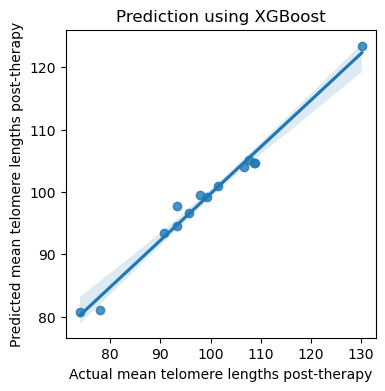

In [9]:
plt.figure(figsize=(4,4))
ax = sns.regplot(x=y_true_list, y=y_predict_list )
ax.set_xlabel('Actual mean telomere lengths post-therapy')
ax.set_ylabel('Predicted mean telomere lengths post-therapy')
ax.set_title('Prediction using XGBoost')

Testing if linear regression can predict 4C mean telos using individual telos¶

In [10]:
lr_model = LinearRegression(normalize=True)

In [11]:
# Fitting the Model
target = '4 C telo means'
features = [col for col in train_clean.columns if col != target]

X_train = train_clean[features].copy()
X_test = test_clean[features].copy()

y_train = train_clean[target].copy()
y_test = test_clean[target].copy()

# fitting the model
fit_lr_model = lr_model.fit(X_train, y_train)

# predict y_test from X_test - this is using the train/test split w/o shuff;ing
predict_y_test = model.predict(X_test)
print(f"MAE of predict_y_test & y_test: {mean_absolute_error(y_test, predict_y_test)}")
print(f'R2 between predict_y_test & y_test: {r2_score(y_test, predict_y_test)}')


MAE of predict_y_test & y_test: 3.2101047384037322
R2 between predict_y_test & y_test: 0.8792315901318282


In [12]:
telo_data = telo_test.copy()
test_set_copy = test_set.copy()

test_set_cleaned =  pd.get_dummies(test_set_copy,columns=['timepoint']).drop(['timepoint_1 non irrad'],axis=1)

features = [col for col in test_set if col != target]
y_predict_list = []
y_true_list = []
patient_ids = []

for patient in list(telo_data['patient id'].unique()):
    # calculate actual mean telomere length per patient w/ all individual telos
    patient_data = telo_data[telo_data['patient id'] == patient]
    actual_4C = patient_data[target].mean()

    # calculate predicted mean telomere length per patient using only test data
    test_patient_data = test_set_cleaned[test_set_cleaned['patient id'] == patient].copy()
    test_patient_data.drop(['patient id', target], axis=1, inplace=True)
    predict_4C = fit_lr_model.predict(test_patient_data)

    y_predict_list.append(np.mean(predict_4C))
    y_true_list.append(actual_4C)
    patient_ids.append(patient)

print(f'MAE predicted vs. actual {target}: {mean_absolute_error(y_true_list, y_predict_list)}')
print(f'R2 predicted vs. actual {target}: {r2_score(y_true_list, y_predict_list)}')

MAE predicted vs. actual 4 C telo means: 9.293565947938902
R2 predicted vs. actual 4 C telo means: 0.07712813009552333


Text(0.5, 1.0, 'Prediction using Linear Regression')

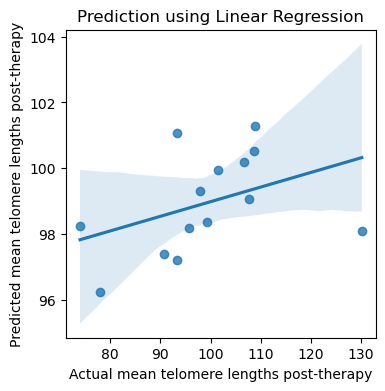

In [13]:
plt.figure(figsize=(4,4))
ax = sns.regplot(x=y_true_list, y=y_predict_list )
ax.set_xlabel('Actual mean telomere lengths post-therapy')
ax.set_ylabel('Predicted mean telomere lengths post-therapy')
ax.set_title('Prediction using Linear Regression')

Machine Learning - exploring predictions of #s of short telomeres post-therapy

In [14]:
# cleaning & combing data; retaining features of interest


quartile_telo_data = pd.read_csv('./data/telos.csv')
patients_df = pd.read_csv("./data/all_patients.csv")

quartile_telo_data = patients_df[patients_df['timepoint']=='4 C'][['patient id','Q1','timepoint']]

quartile_telo_data.rename(columns={'Q1':'4 C # short telos'},inplace= True)
quartile_telo_data = (telos[telos['timepoint'] != '4 C']
        .merge(quartile_telo_data[['4 C # short telos', 'patient id']], on=['patient id'])
        .drop('telo means',axis=1)
       )

quartile_telo_data = quartile_telo_data[quartile_telo_data['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]

quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,79.189944,372
1,1,2 irrad @ 4 Gy,149.932961,372
3,1,1 non irrad,58.072045,372
4,1,2 irrad @ 4 Gy,138.318436,372
6,1,1 non irrad,95.027933,372


In [15]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [16]:
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0, gamma=3)

In [17]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = pd.get_dummies(q_train_clean,columns=['timepoint']).drop(['patient id','timepoint_1 non irrad'],axis=1)
q_test_clean = pd.get_dummies(q_test_clean,columns=['timepoint']).drop(['patient id','timepoint_1 non irrad'],axis=1)

q_train_clean.head()

,individual telomeres,4 C # short telos,timepoint_2 irrad @ 4 Gy
0,59.180978,1298,0
1,94.796657,2585,1
2,101.144660,1298,1
3,102.358335,829,1
4,51.590903,521,0


In [18]:
# q_test_set.sort_values(by='patient id', ascending=True, inplace=True)
# q_test_set.reset_index(drop=True, inplace=True)

In [19]:
# Fitting the Model
target='4 C # short telos'
features = [col for col in q_train_clean.columns if col != target]

X_train = q_train_clean[features].copy()
X_test = q_test_clean[features].copy()

y_train = q_train_clean[target].copy()
y_test = q_test_clean[target].copy()

# fitting the model
q_fit_xgb_model = q_model.fit(X_train, y_train)

# predict y_test from X_test - this is using the train/test split w/o shuff;ing
predict_y_test = q_fit_xgb_model.predict(X_test)
print(f"MAE of predict_y_test & y_test: {mean_absolute_error(y_test, predict_y_test)}")
print(f'R2 between predict_y_test & y_test: {r2_score(y_test, predict_y_test)}')


MAE of predict_y_test & y_test: 235.46431798934935
R2 between predict_y_test & y_test: 0.812922869875551


In [20]:
telo_data = quartile_telo_data.copy()
test_set_copy = q_test_set.copy()

test_set_cleaned =  pd.get_dummies(test_set_copy,columns=['timepoint']).drop(['timepoint_1 non irrad'],axis=1)

features = [col for col in test_set if col != target]
y_predict_list = []
y_true_list = []
patient_ids = []

telo_data
for patient in list(telo_data['patient id'].unique()):
    # calculate actual mean telomere length per patient w/ all individual telos
    patient_data = telo_data[telo_data['patient id'] == patient]
    actual_4C = patient_data[target].mean()

    # calculate predicted mean telomere length per patient using only test data
    test_patient_data = test_set_cleaned[test_set_cleaned['patient id'] == patient].copy()
    test_patient_data.drop(['patient id', target], axis=1, inplace=True)
    predict_4C = q_fit_xgb_model.predict(test_patient_data)

    y_predict_list.append(np.mean(predict_4C))
    y_true_list.append(actual_4C)
    patient_ids.append(patient)

print(f'MAE predicted vs. actual {target}: {mean_absolute_error(y_true_list, y_predict_list)}')
print(f'R2 predicted vs. actual {target}: {r2_score(y_true_list, y_predict_list)}')

MAE predicted vs. actual 4 C # short telos: 215.46863446916853
R2 predicted vs. actual 4 C # short telos: 0.8683546081145239


Text(0.5, 1.0, '#s Prediction using XGBoost')

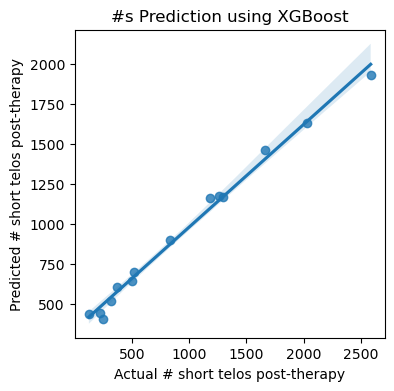

In [21]:
plt.figure(figsize=(4,4))
ax = sns.regplot(x=y_true_list, y=y_predict_list )
ax.set_xlabel('Actual # short telos post-therapy')
ax.set_ylabel('Predicted # short telos post-therapy')
ax.set_title('#s Prediction using XGBoost')